In [1]:
#1
!pip install sentence-transformers transformers tqdm --q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#2
import pandas as pd
train = pd.read_csv("/kaggle/input/d/insanejsk/kdsh-books/Dataset/train.csv")
test = pd.read_csv("/kaggle/input/d/insanejsk/kdsh-books/Dataset/test.csv")
BOOKS_PATH = "/kaggle/input/d/insanejsk/kdsh-books/Dataset/Books"

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/d/insanejsk/kdsh-books/Dataset/train.csv'

In [ ]:
#3
def normalize_book_name(name):
    return name.strip().lower()  # lowercase + strip spaces

train["book_name"] = train["book_name"].apply(normalize_book_name)
test["book_name"] = test["book_name"].apply(normalize_book_name)

In [ ]:
#4
import glob, os
book_texts = {}
for path in glob.glob(os.path.join(BOOKS_PATH, "*.txt")):
    name = os.path.basename(path).replace(".txt","").strip()
    norm_name = name.lower()
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        book_texts[norm_name] = f.read()

In [ ]:
#5
CHUNK_SIZE=800
CHUNK_OVERLAP=200

def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
        i += chunk_size - overlap
    return chunks

book_chunks = {name.lower(): chunk_text(txt) for name, txt in book_texts.items()}

In [ ]:
#6
from sentence_transformers import SentenceTransformer, util
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("multi-qa-mpnet-base-dot-v1", device=device)

embedded_books = {name.lower(): embedder.encode(chunks, convert_to_tensor=True) for name, chunks in book_chunks.items()}

In [ ]:
embedded_books

In [ ]:
#7
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("cross-encoder/nli-deberta-base")
nli_model = AutoModelForSequenceClassification.from_pretrained(
    "cross-encoder/nli-deberta-base"
).to("cuda" if torch.cuda.is_available() else "cpu")

def nli_score(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True).to(nli_model.device)
    with torch.no_grad():
        logits = nli_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    return {
        "contradiction": probs[0],
        "neutral": probs[1],
        "entailment": probs[2]
    }

In [ ]:
from sentence_transformers import util
import numpy as np
def score_backstory_weighted(book_name, backstory_text, top_k=10, sim_threshold=0.5, alpha=1.0, beta=1.0):
    norm_book = book_name.strip().lower()
    memory = {"entail": [], "contradict": []}
    evidence_chunks = []

    book_embs = embedded_books[norm_book]
    book_chunks_list = book_chunks[norm_book]

    back_emb = embedder.encode(backstory_text, convert_to_tensor=True)
    sims = util.cos_sim(back_emb, book_embs)[0]
    top_idx = torch.topk(sims, k=top_k).indices.cpu().numpy()

    for idx in top_idx:
        if sims[idx] < sim_threshold:
            continue
        chunk = book_chunks_list[idx]
        nli = nli_score(chunk, backstory_text)
        
        # BDH-style selective update
        if nli["entailment"] > 0.7:
            memory["entail"].append(nli["entailment"])
            evidence_chunks.append(chunk)
        if nli["contradiction"] > 0.6:
            memory["contradict"].append(nli["contradiction"])

    entail_mean = np.mean(memory["entail"]) if memory["entail"] else 0.0
    contradict_mean = np.mean(memory["contradict"]) if memory["contradict"] else 0.0

    score = alpha * entail_mean - beta * contradict_mean
    pred = 1 if score > 0 else 0
    return pred, score, evidence_chunks


In [ ]:
from tqdm import tqdm
train_preds = []
for _, row in tqdm(train.iterrows(), total=len(train)):
    p, e, c = score_backstory(row["book_name"], row["content"])
    train_preds.append({"id": row["id"], "prediction": p, "entail": e, "contradict": c})

train_results = pd.DataFrame(train_preds)


In [67]:
train_results = train_results.merge(train[["id","label"]], on="id")
train_results["label_bin"] = train_results["label"].map({"consistent":1, "contradict":0})

NameError: name 'train_results' is not defined

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = train_results["label_bin"].values
y_pred = train_results["prediction"].values

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Train Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1-score       : {f1:.4f}")


Train Accuracy : 0.4875
Precision      : 0.6250
Recall         : 0.4902
F1-score       : 0.5495


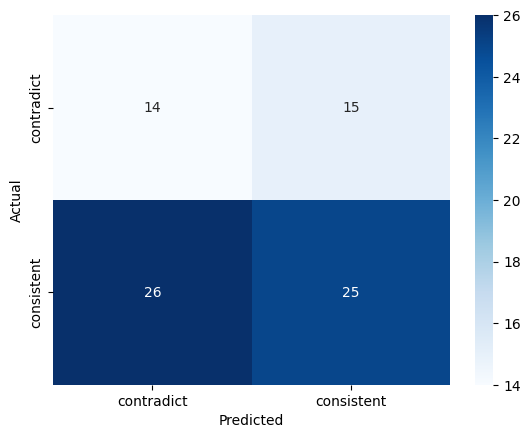

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["contradict","consistent"], yticklabels=["contradict","consistent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
confusion_matrix(y_true, y_pred)

array([[14, 15],
       [26, 25]])

In [3]:
#8
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score

# map train labels to binary
train["label_bin"] = train["label"].map({"consistent":1,"contradict":0})
y_true = train["label_bin"].values

# parameter grid ranges
top_k_choices = [5,7,10,12,15]
sim_threshold_range = (0.4, 0.6)
alpha_range = (0.5, 1.5)
beta_range = (0.5, 1.5)

best_score = 0
best_params = {}

# cache NLI to avoid recomputation
nli_cache = {}

def get_nli(chunk, backstory):
    key = (chunk, backstory)
    if key not in nli_cache:
        nli_cache[key] = nli_score(chunk, backstory)
    return nli_cache[key]

# def score_backstory_weighted(book_name, backstory_text, top_k, sim_threshold, alpha, beta):
#     norm_book = book_name.strip().lower()
#     memory = {"entail": [], "contradict": []}

#     book_embs = embedded_books[norm_book]
#     book_chunks_list = book_chunks[norm_book]

#     back_emb = embedder.encode(backstory_text, convert_to_tensor=True)
#     sims = util.cos_sim(back_emb, book_embs)[0]
#     top_idx = torch.topk(sims, k=top_k).indices.cpu().numpy()

#     for idx in top_idx:
#         if sims[idx] < sim_threshold:
#             continue
#         chunk = book_chunks_list[idx]
#         nli = get_nli(chunk, backstory_text)

#         # BDH-style selective update
#         if nli["entailment"] > 0.7:
#             memory["entail"].append(nli["entailment"])
#         if nli["contradiction"] > 0.6:
#             memory["contradict"].append(nli["contradiction"])

#     entail_mean = np.mean(memory["entail"]) if memory["entail"] else 0.0
#     contradict_mean = np.mean(memory["contradict"]) if memory["contradict"] else 0.0

#     score = alpha * entail_mean - beta * contradict_mean
#     pred = 1 if score > 0 else 0
#     return pred

# # ------------------- K-Fold Random Search -------------------
# n_trials = 50   # number of random parameter samples
# n_splits = 5    # 5-fold CV
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# for _ in tqdm(range(n_trials)):
#     # randomly sample hyperparameters
#     top_k = random.choice(top_k_choices)
#     sim_threshold = random.uniform(*sim_threshold_range)
#     alpha = random.uniform(*alpha_range)
#     beta = random.uniform(*beta_range)

#     fold_scores = []

#     for train_idx, val_idx in kf.split(train):
#         val_preds = []
#         val_labels = y_true[val_idx]

#         for i in val_idx:
#             row = train.iloc[i]
#             p = score_backstory_weighted(
#                 row["book_name"], row["content"], top_k, sim_threshold, alpha, beta
#             )
#             val_preds.append(p)

#         f1 = f1_score(val_labels, val_preds)
#         fold_scores.append(f1)

#     mean_f1 = np.mean(fold_scores)

#     if mean_f1 > best_score:
#         best_score = mean_f1
#         best_params = {
#             "top_k": top_k,
#             "sim_threshold": sim_threshold,
#             "alpha": alpha,
#             "beta": beta,
#             "mean_f1": mean_f1
#         }

# print("Best Random Search with CV Result:")
# print(best_params)

NameError: name 'train' is not defined

In [ ]:
#9
@torch.no_grad()
def score_backstory_weighted(book_name, backstory_text, top_k, sim_threshold, alpha, beta):
    norm_book = book_name.strip().lower()
    memory = {"entail": [], "contradict": []}
    evidence_chunks = []

    book_embs = embedded_books[norm_book]
    book_chunks_list = book_chunks[norm_book]

    back_emb = embedder.encode(backstory_text, convert_to_tensor=True, device=device)
    sims = util.cos_sim(back_emb, book_embs)[0]
    top_idx = torch.topk(sims, k=top_k).indices.tolist()

    for idx in top_idx:
        if sims[idx].item() < sim_threshold:
            continue
        chunk = book_chunks_list[idx]
        nli = get_nli(chunk, backstory_text)

        # BDH-style selective update
        if nli["entailment"] > 0.7:
            memory["entail"].append(nli["entailment"])
            evidence_chunks.append(chunk)   # track rationale
        if nli["contradiction"] > 0.6:
            memory["contradict"].append(nli["contradiction"])
            evidence_chunks.append(chunk)   # track rationale

    entail_mean = np.mean(memory["entail"]) if memory["entail"] else 0.0
    contradict_mean = np.mean(memory["contradict"]) if memory["contradict"] else 0.0

    score = alpha * entail_mean - beta * contradict_mean
    pred = 1 if score > 0 else 0

    return pred, score, evidence_chunks

In [64]:
# Best Random Search with CV Result:
#{'top_k': 15, 'sim_threshold': 0.4128825899953899, 'alpha': 1.3060216504048299, 'beta': 0.7987142657077282, 'mean_f1': np.float64(0.7612535612535613)}

In [ ]:
#10 -- PULKIT BHAI
# ------------------- Run Train & Test -------------------

# Use the best hyperparameters from CV
top_k = 15
sim_threshold = 0.4128825899953899
alpha = 1.3060216504048299
beta = 0.7987142657077282

print(f"Running with optimized params: top_k={top_k}, threshold={sim_threshold:.2f}, alpha={alpha:.2f}, beta={beta:.2f}")

# --------------- TRAIN METRICS ----------------
train_preds = []
train_evidence = []  # optional rationale

for idx, row in tqdm(train.iterrows(), total=len(train)):
    pred, score, evidence_chunks = score_backstory_weighted(
        row["book_name"], row["content"], top_k, sim_threshold, alpha, beta
    )
    train_preds.append(pred)
    train_evidence.append(evidence_chunks)

train_preds = np.array(train_preds)
y_true = train["label_bin"].values

train_acc = (train_preds == y_true).mean()
train_f1 = f1_score(y_true, train_preds)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train F1: {train_f1:.4f}")

# Optional: add rationale column to train dataframe
train["prediction"] = train_preds
train["evidence_chunks"] = train_evidence

# # --------------- TEST PREDICTIONS ----------------
# test_preds = []
# test_evidence = []

# for idx, row in tqdm(test.iterrows(), total=len(test)):
#     pred, score, evidence_chunks = score_backstory_weighted(
#         row["book_name"], row["content"], top_k, sim_threshold, alpha, beta
#     )
#     test_preds.append(pred)
#     test_evidence.append(evidence_chunks)

# # convert to DataFrame for submission
# submission = test.copy()
# submission["prediction"] = test_preds
# submission["evidence_chunks"] = test_evidence
# submission["label"] = submission["prediction"].map({1:"consistent", 0:"contradict"})

# # Save CSV
# submission[["id", "label", "evidence_chunks"]].to_csv("results.csv", index=False)
# print("results.csv ready for submission!")


Running with optimized params: top_k=15, threshold=0.41, alpha=1.31, beta=0.80


100%|██████████| 80/80 [00:00<00:00, 83.93it/s]


KeyError: 'label_bin'

In [78]:
#11
import re
import pandas as pd

train = pd.read_csv("/kaggle/input/d/insanejsk/kdsh-books/Dataset/train.csv")

print(train.shape)
train.head(1)

def split_claims(text):
    parts = re.split(r"[.;]\s+| and | but | however ", text, flags=re.IGNORECASE)
    claims = []

    for p in parts:
        p = p.strip()
        if len(p) > 20:   # ignore very small fragments
            claims.append(p)

    return claims

# Mapping between book names in CSV and actual files
BOOK_PATHS = {
    "The Count of Monte Cristo": "/kaggle/input/d/insanejsk/kdsh-books/Dataset/Books/The Count of Monte Cristo.txt",
    "In Search of the Castaways": "/kaggle/input/d/insanejsk/kdsh-books/Dataset/Books/In search of the castaways.txt"
}

def load_book(book_name):
    """
    Given a book name from the CSV, load and return the full book text.
    """
    path = BOOK_PATHS[book_name]
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def chunk_book(book_text):
    raw_paragraphs = book_text.split("\n\n")

    chunks = []
    idx = 0

    for p in raw_paragraphs:
        p = p.strip()
        if len(p) < 100:
            continue

        chunks.append({
            "idx": idx,
            "text": p
        })
        idx += 1

    return chunks

def extract_keywords(claim):
    """
    Take a claim sentence and extract important words.
    We ignore short words to avoid noise.
    """
    words = claim.lower().split()
    keywords = [w for w in words if len(w) >= 5]
    return keywords

def retrieve_chunks(chunks, character, claim):
    """
    Return book chunks that mention the character
    or contain important keywords from the claim.
    """
    keywords = extract_keywords(claim)
    character = character.lower()

    relevant = []

    for c in chunks:
        text = c["text"].lower()

        if character in text:
            relevant.append(c)
        else:
            for kw in keywords:
                if kw in text:
                    relevant.append(c)
                    break

    return relevant

ABSOLUTE_WORDS = [
    "never",
    "always",
    "only",
    "since childhood",
    "from birth",
    "throughout his life",
    "throughout her life"
]

EVENT_KEYWORDS = [
    "arrested", "re-arrested", "imprisoned", "released",
    "escaped", "escape", "died", "death", "killed",
    "sentenced", "confined"
]

TIME_MARKERS = [
    "again", "this time", "for life"
]

def is_absolute_claim(claim):
    claim = claim.lower()
    for w in ABSOLUTE_WORDS:
        if w in claim:
            return True
    return False

def is_event_claim(claim):
    c = claim.lower()
    has_event = any(k in c for k in EVENT_KEYWORDS)
    has_time = any(t in c for t in TIME_MARKERS) or any(ch.isdigit() for ch in c)
    return has_event and has_time


# %%
def has_hard_contradiction(claim, relevant_chunks):
    """
    Return True if we see a clear contradiction.
    """
    if not is_absolute_claim(claim):
        return False

    for c in relevant_chunks:
        text = c["text"].lower()

        # very simple signals of change or later action
        if "later" in text or "years later" in text or "afterward" in text:
            return True

        if "returned" in text and "never returned" in claim.lower():
            return True

    return False

def has_event_contradiction(claim, relevant_chunks):
    """
    Return True if the book strongly suggests
    an incompatible event history.
    """
    if not is_event_claim(claim):
        return False

    c = claim.lower()

    for ch in relevant_chunks:
        text = ch["text"].lower()

        # If claim implies a new arrest, but book says already imprisoned
        if "re-arrest" in c or "again" in c:
            if "already imprisoned" in text or "had been imprisoned" in text:
                return True
            if "never released" in text:
                return True

        # If claim says 'for life', but book mentions death shortly after
        if "for life" in c:
            if "died" in text or "death" in text:
                return True

    return False


def sanitize_claims(claims):
    clean = []

    for c in claims:
        c = c.strip()

        # Reject very short fragments
        if len(c) < 25:
            continue

        # Reject speculation / soft language
        if any(w in c.lower() for w in [
            "might", "could", "possibly", "perhaps", "likely"
        ]):
            continue

        # Reject explanations
        if any(w in c.lower() for w in [
            "because", "therefore", "suggests that"
        ]):
            continue

        clean.append(c)

    return clean

row = train.iloc[0]
claims = split_claims(row["content"])
claim = claims[0]

relevant_chunks = retrieve_chunks(
    chunks=chunk_book(load_book(row["book_name"])),
    character=row["char"],
    claim=claim
)

def predict_backstory(row):
    claims = split_claims(row["content"])
    book_text = load_book(row["book_name"])
    chunks = chunk_book(book_text)

    for claim in claims:
        relevant_chunks = retrieve_chunks(
            chunks=chunks,
            character=row["char"],
            claim=claim
        )

        # Rule 1: Absolute contradiction
        if has_hard_contradiction(claim, relevant_chunks):
            return 0

        # Rule 2: Event-existence contradiction (NEW)
        if has_event_contradiction(claim, relevant_chunks):
            return 0

    return 1

correct = 0
total = len(train)

for _, row in train.iterrows():
    pred = predict_backstory(row)
    gold = 1 if row["label"] == "consistent" else 0

    if pred == gold:
        correct += 1

accuracy = correct / total
print("TOTAL:", total)
print("CORRECT:", correct)
print("ACCURACY:", accuracy)


(80, 6)
TOTAL: 80
CORRECT: 51
ACCURACY: 0.6375


In [79]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from tqdm import tqdm
# import numpy as np

# # Ground truth
# y_true = train["label"].map({"consistent":1, "contradict":0}).values

# # Hyperparameter ranges
# w_bdh_choices = [0.5, 0.6, 0.7, 0.8, 0.9]
# w_rule_choices = [0.1, 0.2, 0.3, 0.4, 0.5]
# threshold_range = [0.0, 0.5, 1.0]

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# best_avg_f1 = 0
# best_params = {}

# # Wrap hyperparameter grid with tqdm for progress
# for w_bdh in tqdm(w_bdh_choices, desc="w_bdh"):
#     for w_rule in tqdm(w_rule_choices, desc="w_rule", leave=False):
#         for threshold in threshold_range:
#             fold_f1 = []

#             for train_idx, val_idx in kf.split(train):
#                 val_preds = []
#                 val_true = y_true[val_idx]

#                 # Wrap validation fold with tqdm if you want
#                 for idx in val_idx:
#                     row = train.iloc[idx]

#                     # BDH scoring
#                     bdh_pred, bdh_score, _ = score_backstory_weighted(
#                         row["book_name"], row["content"], top_k, sim_threshold, alpha, beta
#                     )

#                     # Rule-based scoring
#                     rule_pred = predict_backstory(row)
#                     rule_score = rule_pred

#                     # Weighted ensemble
#                     combined_score = w_bdh * bdh_score + w_rule * rule_score
#                     final_pred = 1 if combined_score > threshold else 0
#                     val_preds.append(final_pred)

#                 val_preds = np.array(val_preds)
#                 fold_f1.append(f1_score(val_true, val_preds))

#             avg_f1 = np.mean(fold_f1)

#             if avg_f1 > best_avg_f1:
#                 best_avg_f1 = avg_f1
#                 best_params = {
#                     "w_bdh": w_bdh,
#                     "w_rule": w_rule,
#                     "threshold": threshold,
#                     "avg_f1": avg_f1
#                 }

# print("Best 5-Fold CV ensemble params:")
# print(best_params)

w_bdh: 100%|██████████| 5/5 [06:08<00:00, 73.78s/it] 

Best 5-Fold CV ensemble params:
{'w_bdh': 0.6, 'w_rule': 0.4, 'threshold': 0.0, 'avg_f1': np.float64(0.769135334652576)}


In [114]:
#12
def run_ensemble_inference(df, best_params, top_k, sim_threshold, alpha, beta):
    preds = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        _, bdh_score, _ = score_backstory_weighted(
            row["book_name"], row["content"],
            top_k, sim_threshold, alpha, beta
        )

        rule_pred = predict_backstory(row)
        rule_score = rule_pred

        combined = (
            best_params["w_bdh"] * bdh_score +
            best_params["w_rule"] * rule_score
        )

        pred = 1 if combined > best_params["threshold"] else 0
        preds.append(pred)

    return np.array(preds)

In [115]:
train_preds = run_ensemble_inference(train, best_params, top_k, sim_threshold, alpha, beta)
# test_preds  = run_ensemble_inference(test,  best_params, top_k, sim_threshold, alpha, beta)

100%|██████████| 80/80 [00:04<00:00, 16.19it/s]


In [116]:
import sklearn.metrics as m

In [117]:
y_true

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

In [118]:
train_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [119]:
m.accuracy_score(y_true, train_preds)

0.65